In [150]:
from scipy import ndimage
import matplotlib.pyplot as plt
import imageio
import PIL
import numpy as np
import cv2 
import skimage

### Фильтр Гаусса

In [151]:
def draw_pair(first, second, first_gray_scale = False, second_gray_scale = False, tittle = ""):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    plt.suptitle(tittle)
    ax[0].title.set_text('Before')
    ax[1].title.set_text('After')
    if first_gray_scale:
        ax[0].imshow(first, cmap = 'gray')
    else:
        ax[0].imshow(first)
    if second_gray_scale:
        ax[1].imshow(second, cmap = 'gray')
    else:
        ax[1].imshow(second)
    plt.show()

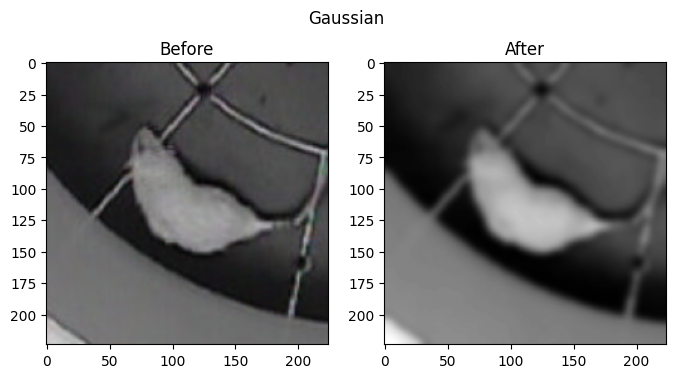

In [152]:
pic = PIL.Image.open(f"mouse.bmp")
sigma = 3
pix = np.array(pic)
result = ndimage.gaussian_filter(pix, sigma)
PIL_image_gaus = PIL.Image.fromarray(np.uint8(result)).convert('L')
draw_pair(pic, PIL_image_gaus, second_gray_scale=True, tittle='Gaussian')

### Фильтр Робертса

In [153]:
roberts_cross_v = np.array([[1, 0 ],
                            [0,-1 ]])
roberts_cross_h = np.array([[ 0, 1 ],
                            [ -1, 0 ]])

b = pic.getbands()  # проверяем, сколько слоев в изображении
print(b)

# преобразуем в серое
pic_L = pic.convert("L")
 
b = pic_L.getbands()  # проверяем, сколько слоев в изображении
print(b)


('R', 'G', 'B')
('L',)


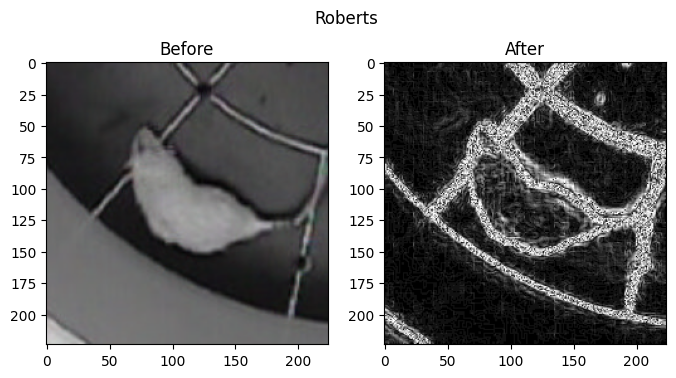

In [154]:
vertical = ndimage.convolve(pic_L, roberts_cross_v)
horizontal = ndimage.convolve(pic_L, roberts_cross_h)
edged_img = np.sqrt( np.square(horizontal) + np.square(vertical))

 
PIL_image = PIL.Image.fromarray(np.uint8(edged_img))
draw_pair(pic, PIL_image, second_gray_scale=True, tittle = 'Roberts')

### Фильтр Прюитт

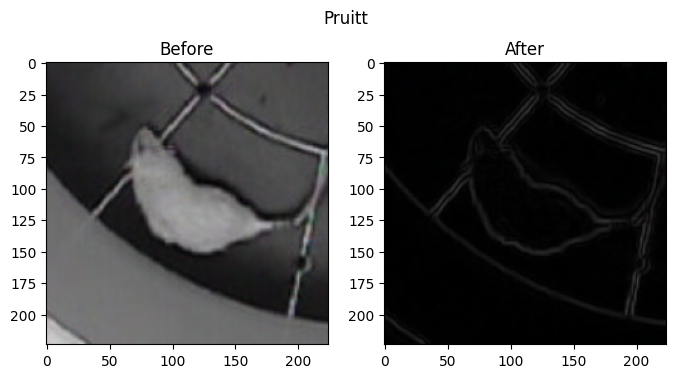

In [155]:

pix = np.array(pic)
input_shape = pix.shape
new_shape = input_shape[1], input_shape[0]
result = skimage.filters.prewitt(pix)
draw_pair(pic, result, tittle = 'Pruitt')

### Фильтр Собеля

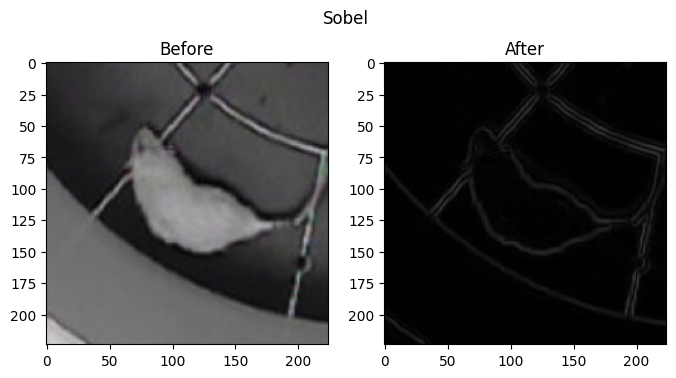

In [156]:
pix = np.array(pic)
input_shape = pix.shape
new_shape = input_shape[1], input_shape[0]
result = skimage.filters.sobel(pix)
draw_pair(pic, result, tittle = 'Sobel')

### Фильтр Лапласа

In [157]:
def LoG_filter(image, sigma, size=None):
    # ядро LoG
    if size is None:
        size = int(6 * sigma + 1) if sigma >= 1 else 7

    if size % 2 == 0:
        size += 1

    x, y = np.meshgrid(np.arange(-size//2+1, size//2+1), np.arange(- size // 2 + 1, size // 2 + 1))
    kernel = -(1/(np.pi * sigma**4)) * (1 - ((x**2 + y**2) / (2 * sigma**2))) * np.exp(- (x**2 + y**2) / (2 * sigma**2))
    kernel = kernel / np.sum(np.abs(kernel))

    result = ndimage.convolve(image, kernel)
    return result

image = cv2.imread("mouse.bmp", cv2.IMREAD_GRAYSCALE)
sigma = 2.0
filtered_image = LoG_filter(image, sigma)

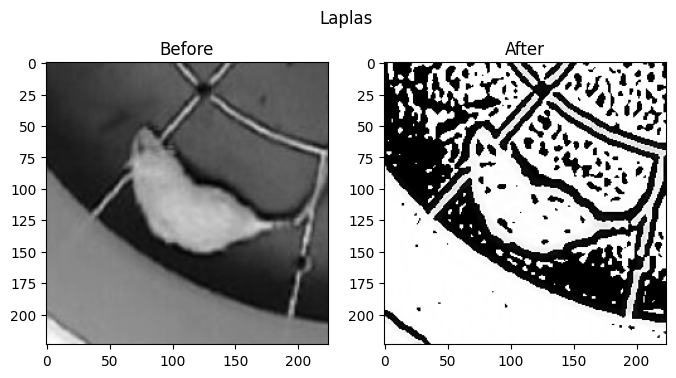

In [158]:
draw_pair(image, filtered_image, True, True, tittle='Laplas')

## Выделение областей

### MeanShift

In [159]:
from sklearn.cluster import MeanShift, estimate_bandwidth

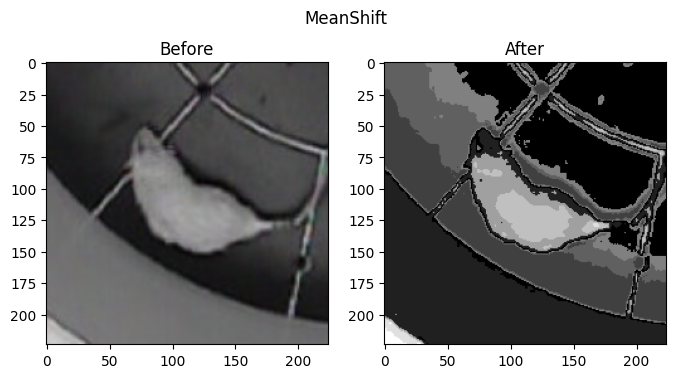

In [160]:
image = PIL.Image.open("mouse.bmp").convert('RGB')

img = np.array(image)
shape = img.shape
new_shape = shape[1], shape[0]
reshaped_image = np.reshape(image, [-1, 3])
bandwidth = estimate_bandwidth(reshaped_image, quantile=0.1, n_samples=300)

msc = MeanShift(bandwidth=bandwidth, bin_seeding=True)
msc.fit(reshaped_image)

labels = msc.labels_
result_image = np.reshape(labels, shape[:2])
draw_pair(img, result_image, second_gray_scale= True, tittle='MeanShift')

### Floodfill

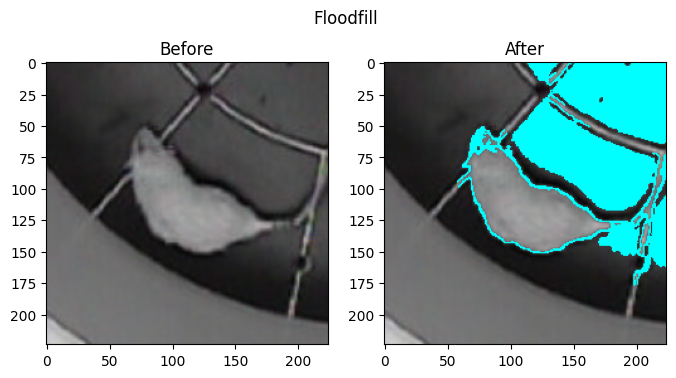

In [161]:
img = cv2.imread('mouse.bmp')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

copyimg = img.copy()
h, w = copyimg.shape[:2]
mask = np.zeros([h + 2, w + 2], np.uint8)

# нужно задать координаты точек - центров заливки. Без этого работать не будет!

cv2.floodFill(copyimg, mask, (165,60), (0, 255, 255), (50, 20, 50), (50, 50 ,30), cv2.FLOODFILL_FIXED_RANGE)

draw_pair(img, copyimg, tittle='Floodfill')

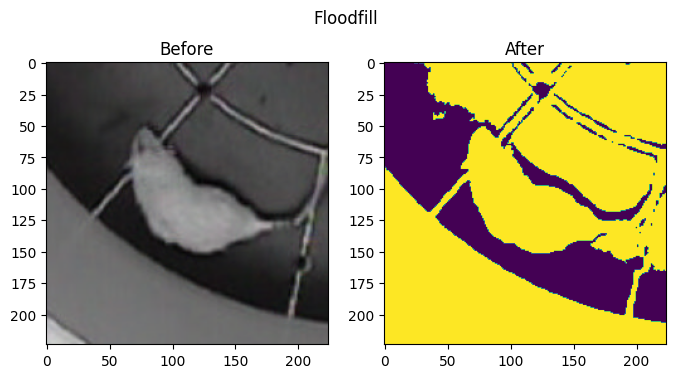

In [162]:
image = cv2.imread("mouse.bmp")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

lower_bound = 50
upper_bound = 50

(thresh, BnW_image) = cv2.threshold(gray_image, lower_bound, upper_bound, cv2.THRESH_BINARY)
im = PIL.Image.fromarray(BnW_image)
im.save("threshold_test.jpg")
draw_pair(img, im, tittle='Floodfill')

## Зашумление и удаление шумов

### Гауссов шум

In [163]:
# здесь представлен пример формирования шума на сером изображении, пример на
# цветном будет ниже

img = cv2.imread('mouse.bmp')
img_gray = img[:,:,1]
noise = np.random.normal(0, 50, img_gray.shape) 
img_noised = img_gray + noise
img_noised = np.clip(img_noised, 0, 255).astype(np.uint8)

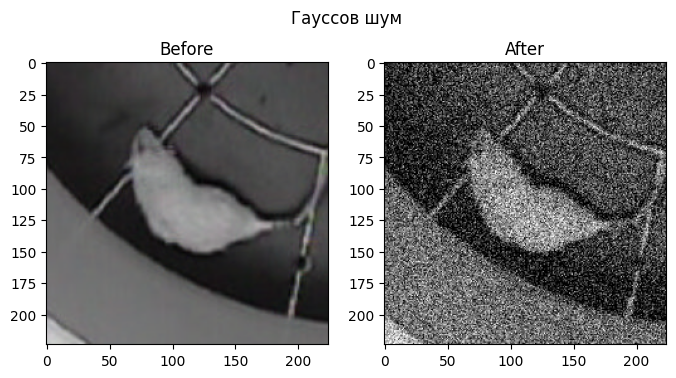

In [164]:
draw_pair(img, img_noised, second_gray_scale=True, tittle='Гауссов шум')

### Импульсный шум

In [165]:
x = np.arange(0, 360, 1)
y = np.sin(np.deg2rad(x))

noise_sample = np.random.default_rng().uniform(0.2*min(y), 0.3*max(y), int(0.03*len(y)))
zeros = np.zeros(len(y) - len(noise_sample))
noise = np.concatenate([noise_sample, zeros])
np.random.shuffle(noise)
y_noised = y + noise

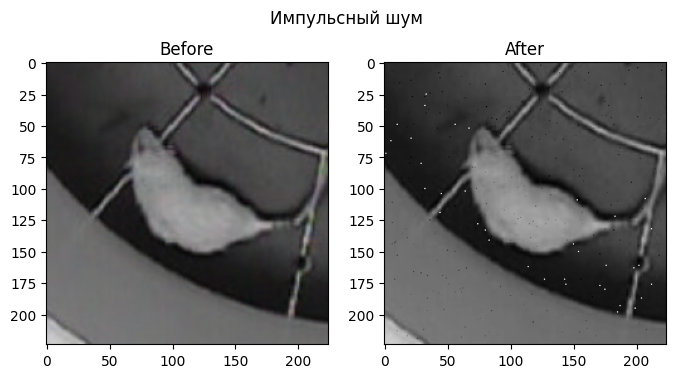

In [166]:
image = cv2.imread("mouse.bmp")
 
h, w = image.shape[:2]

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

s = 300  # количество точек - шума

noise_sample = np.random.default_rng().uniform(low=200, high=250, size=s)
 
rs1 = np.random.randint(0,gray.size/h-1,s)
rs2 = np.random.randint(0,gray.size/w-1,s)

j = 0

# добавляем шум
for i in noise_sample:
    gray[rs2[j]][rs1[j]] += i
    j += 1
 
draw_pair(image, gray, second_gray_scale=True, tittle='Импульсный шум')

### Шум соли и перца (Salt-and-Pepper)

In [167]:
img_size = img_gray.size
noise_percentage = 0.1
noise_size = int(noise_percentage*img_size)

random_indices = np.random.choice(img_size, noise_size)
img_noised = img_gray.copy()
noise = np.random.choice([img_gray.min(), img_gray.max()], noise_size)
img_noised.flat[random_indices] = noise

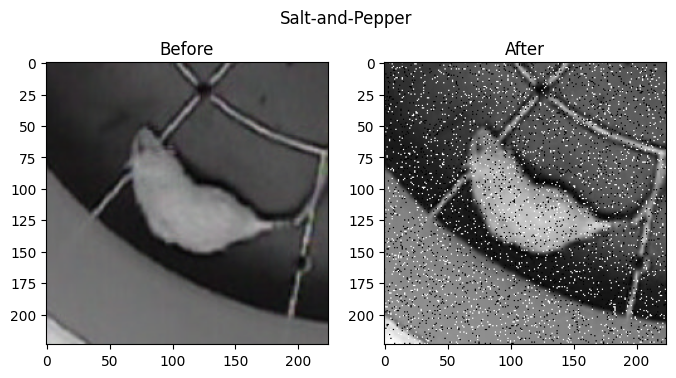

In [168]:
draw_pair(img, img_noised, second_gray_scale=True, tittle='Salt-and-Pepper')

### Шум квантования

In [169]:
# Генерация исходного сигнала-примера
x = np.arange(0, 100, 2)
y = 0.3 * x + 0.6

# Генерация шума
y_size = len(y)
noise_percentage = 0.2
noise_size = int(noise_percentage * y_size)
random_indices = np.random.choice(y_size, noise_size)
y_noised = y.copy()
y_noised[random_indices] = np.rint(y_noised[random_indices])

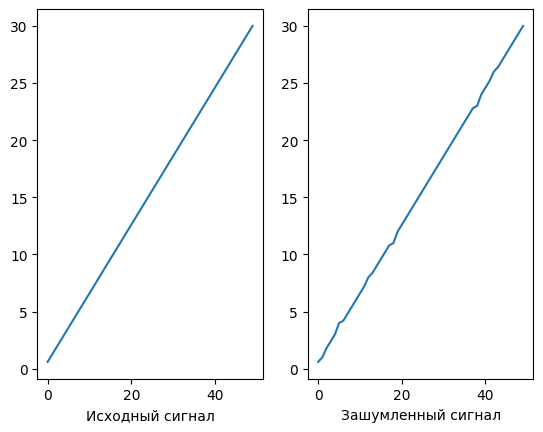

In [170]:
plt.subplot(121)
plt.plot(y)
plt.xlabel("Исходный сигнал")
plt.subplot(122)
plt.plot(y_noised)
plt.xlabel("Зашумленный сигнал")
plt.show()

### Удаление шума из изображения и видео

In [173]:
img = cv2.imread('mouse.bmp')
img_gray = img[:,:,1]
noise = np.random.normal(0, 50, img_gray.shape) 
img_noised = img_gray + noise
img_noised = np.clip(img_noised, 0, 255).astype(np.uint8)

In [174]:
img = img_noised

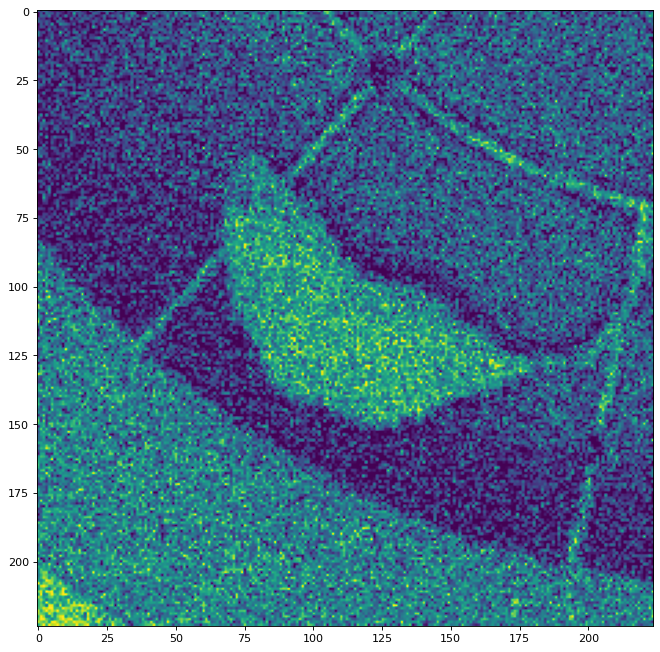

In [175]:
plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(img) 